In [ ]:
'''
Background:
Product Hunt is a popular website where users can share and discover new products. 
The platform allows users to submit products and vote for their favorites on a daily basis. 
The objective of this project is to analyze the latest trends in products by creating two plots:

Latest Product Trend by Top 30 Hashtags (Last 30 Days)
This plot will show the popularity of different hashtags associated with products over the past 30 days. 
By analyzing the frequency of hashtags, we can identify the most trending topics and understand user interests.

Total Upvotes of Top 30 Hashtags
This plot will display the total number of upvotes received for products associated with the top 30 hashtags. 
By examining the upvote counts, we can gain insights into the overall popularity and engagement levels of different product categories.

Methodologies:
To achieve these objectives, we will utilize web scraping techniques on the 
product archive page (https://www.producthunt.com/leaderboard/daily/2024/1/13) for a period of 30 days. 
For each day within this timeframe, we will extract information on the top 10 products and store them in a dataframe.

Once we have collected the necessary data, we will create two charts to visualize the trends. 
The first chart will showcase the latest product trends by displaying the frequency of the top 30 hashtags over the past 30 days. 
The second chart will demonstrate the total upvotes received by products associated with these top 30 hashtags.

By analyzing these plots, we aim to gain valuable insights into the current product landscape, 
identify emerging trends, and understand user preferences and engagement levels.
'''

In [1]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install selenium_stealth

Note: you may need to restart the kernel to use updated packages.


In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium_stealth import stealth
import random

In [8]:
# config
num_track_day = 30

In [9]:
# set up selenium in stealth mode to pass through cloudflare
base_url = 'https://www.producthunt.com/leaderboard/daily/'
user_agents = [
    # Add your list of user agents here
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15',
]
user_agent = 'Mozilla/5.0 (iPhone; CPU iPhone OS 16_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.6 Mobile/15E148 Safari/604.1'

service = ChromeService(executable_path=ChromeDriverManager().install())

user_agent = random.choice(user_agents)
# create ChromeOptions object
options = webdriver.ChromeOptions()
#run in headless mode
options.add_argument("--headless")
# disable the AutomationControlled feature of Blink rendering engine
options.add_argument('--disable-blink-features=AutomationControlled')
# disable pop-up blocking
options.add_argument('--disable-popup-blocking')
# start the browser window in maximized mode
options.add_argument('--start-maximized')
# disable extensions
options.add_argument('--disable-extensions')
# disable sandbox mode
options.add_argument('--no-sandbox')
# disable shared memory usage
options.add_argument('--disable-dev-shm-usage')
options.add_argument(f'user-agent={user_agent}')
options.add_experimental_option(
        "prefs", {
            # block image loading
            "profile.managed_default_content_settings.images": 2,
        }
    )

# create a new Chrome webdriver instance, passing in the Service and options objects
driver = webdriver.Chrome(service=service, options=options)
driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
driver.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": user_agent})

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

headers = {
    'User-Agent': user_agent
}

In [10]:
# initialize variables
# current_date should be yesterday to ensure the voting was finished
df = pd.DataFrame()
current_date = datetime.now().date() - timedelta(days=1)
current_date

datetime.date(2024, 1, 12)

In [11]:
# loop by number of configured day
# parse the html and insert into dataframe
for i in range(num_track_day):
    delta = timedelta(days=i)
    date = current_date - delta
    year = date.year
    day = date.day
    month = date.month
    url = base_url + f'{year}/{month}/{day}'
    print("Fetching ",url)
    driver.get(url)

    # Wait for page to load
    while driver.execute_script("return document.readyState") != "complete":
        # print(driver.execute_script("return document.readyState"))
        pass
    # response = requests.get(url, headers=headers)
    soup = BeautifulSoup(driver.page_source, "html.parser")
    productsHtml = soup.findAll("div", class_ = "styles_item__Dk_nz")
    isDiv = True
    if len(productsHtml) == 0:
        productsHtml = soup.findAll("li", class_ = "styles_item__Dk_nz")
        isDiv = False

    for productHtml in productsHtml[0:10]:
        try:
            # print("is div:", isDiv)
            if isDiv:
                # retrieve name
                title_div = productHtml.find('div', class_='styles_titleTaglineItem__d5Rut')
                title = title_div.text.strip().split("<!-- -->")[0]
                title = title.split('—')[0]
                # print(title)
                # retrieve hashtags
                num_upvotes_div = productHtml.find('div', class_='styles_voteCountItem__zwuqk')
                num_upvotes = int(num_upvotes_div.text.strip().replace(',', ''))
                # print(num_upvotes)
                # retrieve hashtags
                hashtagDivs = productHtml.find_all(class_="styles_underlinedLink__pq3Kl")
                hashtag = ','.join([element.text for element in hashtagDivs if "#" in element.text])
                # print(hashtag)
            else:
                # retrieve name
                titieLink = productHtml.find('a')
                title = titieLink['aria-label']
                # print(title)
                num_upvotes_div = productHtml.find('div', class_='color-lighter-grey fontSize-12 fontWeight-600')
                num_upvotes = int(num_upvotes_div.text.strip().replace(',', ''))
                # print(num_upvotes)
                hashtagDivs = productHtml.find_all(class_="styles_underlinedLink__pq3Kl")
                hashtag = ','.join([element.text for element in hashtagDivs if "#" in element.text])
                # print(hashtag)

                
            product_data = {"title": title, "upvotes": num_upvotes, "hashtags": hashtag, "date": date}
            df = pd.concat([df, pd.DataFrame(product_data, index=[0])], ignore_index=True)
        except Exception as e:
            print(e)
            print(productHtml)

    time.sleep(2)

driver.quit()            
print(df)

Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/12
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/11
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/10
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/9
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/8
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/7
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/6
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/5
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/4
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/3
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/2
Fetching  https://www.producthunt.com/leaderboard/daily/2024/1/1
Fetching  https://www.producthunt.com/leaderboard/daily/2023/12/31
Fetching  https://www.producthunt.com/leaderboard/daily/2023/12/30
Fetching  https://www.producthunt.com/leaderboard/daily/2023/12/29
Fetching  https:

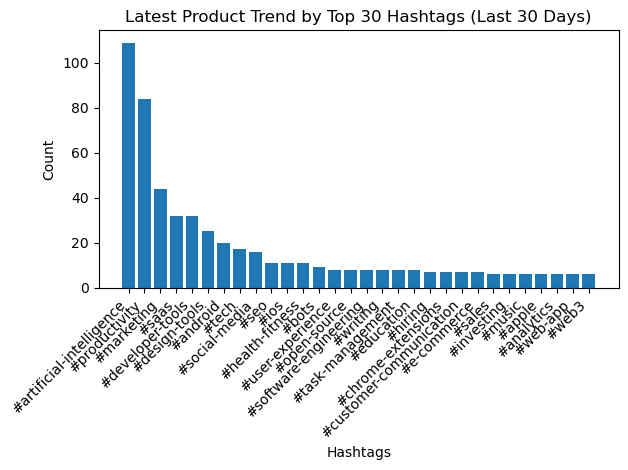

In [16]:
# Group by hashtags and count the occurrences
# Split joined string of hashtags into individual hashtags
df['hashtags'] = df['hashtags'].str.split(',')

# Create a new column for each hashtag
df = df.explode('hashtags')

# Group by hashtag and count occurrences
hashtag_counts = df['hashtags'].value_counts().sort_values(ascending=False)

# Plot the bar chart
hashtag_counts = hashtag_counts.head(30)
plt.bar(hashtag_counts.index, hashtag_counts.values)
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.title('Latest Product Trend by Top 30 Hashtags (Last 30 Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

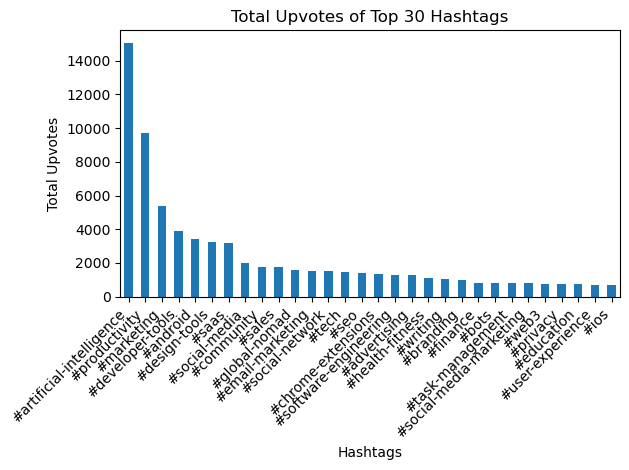

In [15]:
# Group by hashtag and sum the counts
totals = df.groupby('hashtags')['upvotes'].sum().sort_values(ascending=False)
totals = totals.head(30)
# Plot the total count of each hashtag
totals.plot(kind='bar')

# Set plot labels
plt.xlabel('Hashtags')
plt.ylabel('Total Upvotes')
plt.title('Total Upvotes of Top 30 Hashtags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:
'''
Conclusion:
Based on the analysis of the data collected from Product Hunt over the last 30 days, 
it is evident that the AI category emerged as the top product category. 
This category not only had the highest number of products ranked within the top 10 but also received the highest number of upvotes overall. 
The AI category showcases the significant interest and engagement of Product Hunt users in artificial intelligence-related products.

Following the AI category, the productivity and marketing categories were observed to be the next most prominent product categories. 
These categories also had a notable presence within the top 10 rankings and received substantial upvotes, 
indicating their popularity among Product Hunt users.

It is important to note that these observations are specific to the data collected during the analyzed period and 
may be subject to change over time as new products and trends emerge. 
Continuous monitoring and analysis of Product Hunt data can provide ongoing insights into evolving product categories and user preferences.
'''